# Lecture 4: Numerical Integration
## CHME 5630 - Spring 2020
This notebook goes through the steps involved in implementing two different proceudres for integrating ordinary differential equations that we will see in this course that are are tricky (or impossible) to solve analytically.

The first is **Euler's method**, which we also implemented explicitly in Excel

For a function $$\frac{dy}{dt}=f(t,y)$$
where $y(0) = y_0$, we introduce the approximation
$$\frac{\Delta y}{\Delta t}=\frac{y_{n+1}-y_{n}}{t_{n+1}-t_{n}}\approx f(t_n,y_n)$$
using a small time step $\Delta t = t_{n+1}-t_{n}$
This gives us $$y_{n+1}=y_n+\Delta t\cdot f(t_n,y_n)$$
To implement this method, we calculate the value of the derivative at the current value of $y$, and calculate the next value $y_{n+1}$ by adding the product of the derivative and the time step.

The second is to use a built-in ODE solver from the scipy package, called **odeint**. The main advantage of this approach is that, unlike in Euler's method, which uses fixed time steps, odeint automatically adjusts the time steps. This is useful in **stiff** problems that have multiple different time scales. Enzymatic conversions are a good example of this, where in the first part of the reaction where $S>>K_m$ conversion is linear with time and we can take large time steps, but when the substrate begins to run out $(S \approx K_m)$, a large time step might introduce numerical error (e.g. leading  to a negative substrate concentration).

First, we import the packages we need:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint #This part is only need for odeint, not Euler's method
%matplotlib inline

Next, we'll define the variables we will need for both approaches, starting with the kinetic and process parameters

In [3]:
v_max = 0.0596 #mM/min
Km = 5.0 #mM (Note that if we had typed '5' instead of '5.0', python would have treated this value as an integer, which can cause problems with future math manipulations)
S0 = 50.0 #mM
P0 = 0.0
I = 1.0 #mM
Ki = 1.0 #mM

Now, let's implement **Euler's method**. First we define our time increment:

In [4]:
tinc = 10 #s

Now we define our derivative functions (one for product, and one for substrate), which we get from the mass balances,

$$\frac{dS}{dt}=-\frac{V_{max}S}{K_m+S}$$

$$\frac{dP}{dt}=\frac{V_{max}S}{K_m+S}$$

The way we'll do this is to have a single **deriv** function that returns both $\frac{d[P]}{dt}$ and $\frac{d[S]}{dt}$

In [5]:
def deriv(S):
    dSdt = -1 * v_max * S / (Km + S)
    dPdt = v_max * S / (Km + S)
    return [dSdt, dPdt] #Here we are returning a list, where the first element is dSdt and the second is dPdt

Now we define a function that automates the Euler process, called **euler()**, that takes as inputs the initial conditions (init), the time step (tstep), the end time to stop calculating the values of S and P (tstop). First, we create three output lists where we'll store the time, [S] and [P] data. Then we'll start a loop. In the loop we'll call the **deriv** method to calculate the derivatives at teh current value of [S], then calculate the next values of t, [S], and [P], and append them to the relevant list. The loop will stop when the simulation time gets to the final time we're interested in. 

In [6]:
def euler(init, tstep, tstop):
    t = 0 #Define the starting time
    
    #Define lists to store the time, substrate and product values for plotting later
    time = [0]
    S = [init[0]]
    P = [init[1]]
   
    #Loop until we've hit the end of the simulation time
    while t < tstop:
        [dSdt, dPdt] = deriv(S[-1]) #Calculate the derivatives based on the current value of S (-1 refers to the last elemetn in a list)
        S.append(dSdt*tstep+S[-1]) #Calculate the next value of S and add that new value of S to the end of the list
        P.append(dPdt*tstep+P[-1]) #Calculate the next value of P and add that new value of P to the end of the list
        t = time[-1]+tstep #Update the simulation time
        time.append(t) #Add the current value of time to the end of the t list
        
    return time, P, S #Return the data to the calling function
    

Now we're all set to run. We'll call the **euler** method we defined, feeding it the initial substrate and product concentrations, the time increment, and the stopping time

In [7]:
time, P, S = euler([S0, P0], tinc, 1400)

Let's plot the results

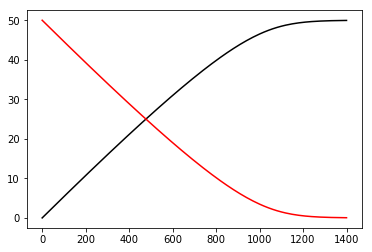

In [8]:
plt.plot(time,P,'k')
plt.plot(time,S,'r')

These look similar to what we found when we used Excel. You may want to do further manipulation with these lists, e.g. finding the time point that corresponds to a certain substrate level. These sorts of things can be done in Python, and I encourage you to look for creative ways to this. An alternative is to save the raw data into an Excel file for simpler manipulation:

In [23]:
import pandas as pd #Pandas is a really useful library providing data structures and data analysis tools

df = pd.DataFrame({'Time (s)': time, #First, we convert our lists to a Pandas dataframe, with headers
                    'S (mM)': S,
                    'P (mM)': P})

df.to_excel('simulation_results.xls',"Sheet 1", startrow=1, columns=['Time (s)','S (mM)','P (mM)']) #Next, we use the built-in functionality of pandas to save the data to an Excel file.
    